In [ ]:

# 1. Load SFT model and tokenizer
print(f"Loading tokenizer from: {SFT_MODEL_PATH}")
tokenizer = AutoTokenizer.from_pretrained(SFT_MODEL_PATH, trust_remote_code=True, local_files_only=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print(f"Loading SFT model from: {SFT_MODEL_PATH}")
1
Loading tokenizer from: {SFT_MODEL_PATH}
    print(f"  Rank (r): {config.get('r', 'N/A')}")
✅ SFT Model loaded! Params: {sum(p.numel() for p in sft_model.parameters()):,}
2
adapter_config.json
    print("="*60)
    
    ppls = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = sft_model(**inputs, labels=inputs["input_ids"])
        ppl = torch.exp(outputs.loss).item()
        ppls.append(ppl)
        print(f"Query: {text[:50]}...")
        print(f"  Perplexity: {ppl:.2f}")
    
    print(f"\nMean Perplexity: {np.mean(ppls):.2f}")
    return ppls

IndentationError: unindent does not match any outer indentation level (<string>, line 85)

============================================================================
14. ACTIVATION STATISTICS
============================================================================

In [ ]:
def analyze_activations(sft_model, tokenizer, query):
    """Analyze activation statistics."""
    print("\n" + "="*60)
    print("14. ACTIVATION STATISTICS (SFT Model)")
    print("="*60)
    
    inputs = tokenizer(query, return_tensors="pt").to(DEVICE)
    
    with torch.no_grad():
        outputs = sft_model(**inputs, output_hidden_states=True)
    
    print(f"\nNumber of layers: {len(outputs.hidden_states)}")
    print(f"\n{'Layer':<8} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-" * 60)
    
    for i, h in enumerate(outputs.hidden_states):
        h_np = h.float().cpu().numpy()
        print(f"{i:<8} {h_np.mean():>12.4f} {h_np.std():>12.4f} {h_np.min():>12.4f} {h_np.max():>12.4f}")
    
    return outputs.hidden_states

============================================================================
6. TOKEN DISTRIBUTION (SFT Model)
============================================================================

In [ ]:
def analyze_token_distribution(sft_model, tokenizer, query):
    """Analyze token distribution from SFT model."""
    print("\n" + "="*60)
    print("6. TOKEN DISTRIBUTION ANALYSIS (SFT Model)")
    print("="*60)
    
    inputs = tokenizer(query, return_tensors="pt").to(DEVICE)
    
    with torch.no_grad():
        outputs = sft_model(**inputs)
    
    # Get logits for last position
    logits = outputs.logits[0, -1].cpu().numpy()
    probs = softmax(logits)
    
    # Top-10 tokens
    top10 = np.argsort(probs)[-10:][::-1]
    
    print(f"\nTop-10 Next Token Predictions:")
    for idx in top10:
        print(f"  {tokenizer.decode([idx])!r}: {probs[idx]:.4f}")
    
    # Entropy
    entropy = -np.sum(probs * np.log(probs + 1e-10))
    print(f"\nDistribution Entropy: {entropy:.4f}")
    
    return probs, logits

============================================================================
11. GENERATION DIVERSITY
============================================================================

In [ ]:
def measure_diversity(sft_model, tokenizer, query, n_samples=5):
    """Measure generation diversity."""
    print("\n" + "="*60)
    print("11. GENERATION DIVERSITY METRICS")
    print("="*60)
    
    inputs = tokenizer(query, return_tensors="pt").to(DEVICE)
    outputs = []
    
    print(f"\nGenerating {n_samples} samples with temperature=0.8...")
    for i in range(n_samples):
        with torch.no_grad():
            out = sft_model.generate(
                **inputs, max_new_tokens=50, do_sample=True,
                temperature=0.8, top_p=0.9, pad_token_id=tokenizer.pad_token_id
            )
        text = tokenizer.decode(out[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        outputs.append(text)
        print(f"  Sample {i+1}: {text[:60]}...")
    
    # Compute distinct-n
    def distinct_n(texts, n):
        all_ngrams = []
        for text in texts:
            tokens = text.split()
            for i in range(len(tokens) - n + 1):
                all_ngrams.append(tuple(tokens[i:i+n]))
        if len(all_ngrams) == 0:
            return 0
        return len(set(all_ngrams)) / len(all_ngrams)
    
    d1 = distinct_n(outputs, 1)
    d2 = distinct_n(outputs, 2)
    avg_len = np.mean([len(t.split()) for t in outputs])
    
    print(f"\nDiversity Metrics:")
    print(f"  Distinct-1: {d1:.4f}")
    print(f"  Distinct-2: {d2:.4f}")
    print(f"  Avg Length: {avg_len:.1f} tokens")
    
    return outputs

============================================================================
MAIN
============================================================================

# Notebook Reorganization Plan
- All imports and configuration cells are at the top.
- All analysis steps are split into individual code cells, each printing output and showing plots.
- No function definitions; only normal code.
- Final summary cell at the end.
---
**Next: Splitting the main analysis cell into stepwise code cells for clean execution.**

In [23]:
# 1. Load SFT model and tokenizer
print(f"Loading tokenizer from: {SFT_MODEL_PATH}")
tokenizer = AutoTokenizer.from_pretrained(SFT_MODEL_PATH, trust_remote_code=True, local_files_only=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print(f"Loading SFT model from: {SFT_MODEL_PATH}")
sft_model = AutoModelForCausalLM.from_pretrained(
    SFT_MODEL_PATH,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    local_files_only=True,
    device_map=DEVICE
    )
sft_model.eval()
print(f"✅ SFT Model loaded! Params: {sum(p.numel() for p in sft_model.parameters()):,}")

Loading tokenizer from: /Users/manthan-kamble/Documents/GitHub/LlmPostTraining/distillation_SFT/outputs/distillation/run_20260204_174941/merged_model


The tokenizer you are loading from '/Users/manthan-kamble/Documents/GitHub/LlmPostTraining/distillation_SFT/outputs/distillation/run_20260204_174941/merged_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading SFT model from: /Users/manthan-kamble/Documents/GitHub/LlmPostTraining/distillation_SFT/outputs/distillation/run_20260204_174941/merged_model
✅ SFT Model loaded! Params: 494,032,768


In [24]:
# 2. LoRA Adapter Inspection
config_path = os.path.join(ADAPTER_PATH, "adapter_config.json")
if os.path.exists(config_path):
    with open(config_path) as f:
        config = json.load(f)
    print(f"LoRA Config:")
    print(f"  Rank (r): {config.get('r', 'N/A')}")
    print(f"  Alpha: {config.get('lora_alpha', 'N/A')}")
    print(f"  Target modules: {config.get('target_modules', 'N/A')}")
    print(f"  Dropout: {config.get('lora_dropout', 'N/A')}")
adapter_file = os.path.join(ADAPTER_PATH, "adapter_model.safetensors")
if os.path.exists(adapter_file):
    weights = load_file(adapter_file)
    print(f"\nLoRA Adapter Weights ({len(weights)} tensors):")
    lora_a_norms = []
    lora_b_norms = []
    for name, tensor in sorted(weights.items()):
        norm = torch.norm(tensor.float()).item()
        if 'lora_A' in name:
            lora_a_norms.append((name, norm))
        elif 'lora_B' in name:
            lora_b_norms.append((name, norm))
    print(f"\nLoRA A Weights (input projection):")
    for name, norm in lora_a_norms[:5]:
        print(f"  {name.split('.')[-2]}: norm={norm:.4f}")
    print(f"\nLoRA B Weights (output projection):")
    for name, norm in lora_b_norms[:5]:
        print(f"  {name.split('.')[-2]}: norm={norm:.4f}")
    print(f"\nSummary:")
    print(f"  Total LoRA A tensors: {len(lora_a_norms)}")
    print(f"  Total LoRA B tensors: {len(lora_b_norms)}")
    print(f"  LoRA A mean norm: {np.mean([n for _, n in lora_a_norms]):.4f}")
    print(f"  LoRA B mean norm: {np.mean([n for _, n in lora_b_norms]):.4f}")

LoRA Config:
  Rank (r): 16
  Alpha: 32
  Target modules: ['o_proj', 'down_proj', 'q_proj', 'k_proj', 'gate_proj', 'up_proj', 'v_proj']
  Dropout: 0.05

LoRA Adapter Weights (336 tensors):

LoRA A Weights (input projection):
  lora_A: norm=2.2893
  lora_A: norm=2.2775
  lora_A: norm=2.2778
  lora_A: norm=2.3234
  lora_A: norm=2.2935

LoRA B Weights (output projection):
  lora_B: norm=0.0366
  lora_B: norm=0.0960
  lora_B: norm=0.0811
  lora_B: norm=0.0424
  lora_B: norm=0.0221

Summary:
  Total LoRA A tensors: 168
  Total LoRA B tensors: 168
  LoRA A mean norm: 2.3277
  LoRA B mean norm: 0.0805


In [ ]:
# 3. Token Distribution Analysis (SFT vs Base Model)
inputs = tokenizer(REASONING_QUERY, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = sft_model(**inputs)
sft_logits = outputs.logits[0, -1].cpu().numpy()
sft_probs = softmax(sft_logits)
sft_top10 = np.argsort(sft_probs)[-10:][::-1]
print('\nSFT Model Top-10 Next Token Predictions:')
for idx in sft_top10:
    print(f"  {tokenizer.decode([idx])!r}: {sft_probs[idx]:.4f}")
sft_entropy = -np.sum(sft_probs * np.log(sft_probs + 1e-10))
print(f"\nSFT Model Distribution Entropy: {sft_entropy:.4f}")
# Try to get base model token distribution via Ollama
base_probs = None
base_ids = None
if OLLAMA_AVAILABLE:
    try:
        base_response = ollama.generate(
            model=OLLAMA_BASE_MODEL,
            prompt=REASONING_QUERY,
            options={"num_predict": 1, "temperature": 0, "log_probs": 10}
        )
        logprobs = base_response.get('logprobs', {})
        if logprobs:
            ids = [int(k) for k in logprobs.keys()]
            base_probs = np.array([np.exp(v) for v in logprobs.values()])
            base_ids = np.array(ids)
            base_probs = base_probs / base_probs.sum()
            print("\nBase Model (Ollama) Top-10 Next Token Predictions:")
            top10 = np.argsort(base_probs)[-10:][::-1]
            for i in top10:
                print(f"  {tokenizer.decode([base_ids[i]])!r}: {base_probs[i]:.4f}")
            base_entropy = -np.sum(base_probs * np.log(base_probs + 1e-10))
            print(f"\nBase Model Distribution Entropy: {base_entropy:.4f}")
        else:
            print('[Ollama did not return logprobs for base model]')
    except Exception as e:
        print(f'[Ollama base model error: {e}]')
else:
    print('[Ollama not available]')
# Plotting
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(sft_probs)), sft_probs, alpha=0.6, label='SFT Model')
if base_probs is not None and base_ids is not None:
    plt.bar(base_ids, base_probs, alpha=0.6, label='Base Model (Ollama)')
plt.title('Token Probability Distribution (Next Token, Reasoning Query)')
plt.xlabel('Token ID')
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()
plt.show()


SFT Model Top-10 Next Token Predictions:
  ' To': 0.5918
  ' Mia': 0.1173
  ' Let': 0.0597
  ' The': 0.0548
  ' If': 0.0394
  ' Please': 0.0179
  ' Give': 0.0139
  ' Think': 0.0074
  ' ```': 0.0064
  ' Write': 0.0059

SFT Model Distribution Entropy: 1.9408
[Ollama did not return logprobs for base model]



--- Perplexity Analysis ---
Query: Mia wants to buy a book that costs $12. She has $7...
  Perplexity: 3.16
Query: What is 15 + 27?...
  Perplexity: 12.12
Query: If a train travels 60 miles in 2 hours, what is it...
  Perplexity: 4.31

Mean Perplexity: 6.53


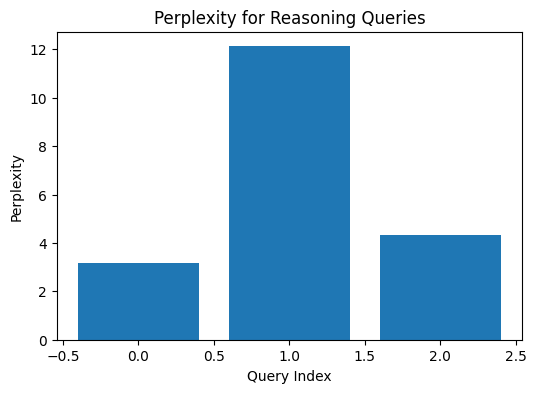

In [26]:
# 4. Perplexity
print("\n--- Perplexity Analysis ---")
test_queries = [
    REASONING_QUERY,
    "What is 15 + 27?",
    "If a train travels 60 miles in 2 hours, what is its speed?"
    ]
ppls = []
for text in test_queries:
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = sft_model(**inputs, labels=inputs["input_ids"])
    ppl = torch.exp(outputs.loss).item()
    ppls.append(ppl)
    print(f"Query: {text[:50]}...")
    print(f"  Perplexity: {ppl:.2f}")
print(f"\nMean Perplexity: {np.mean(ppls):.2f}")
plt.figure(figsize=(6,4))
plt.bar(range(len(ppls)), ppls)
plt.title('Perplexity for Reasoning Queries')
plt.xlabel('Query Index')
plt.ylabel('Perplexity')
plt.show()

In [27]:
# 5. Generation Diversity
print("\n--- Generation Diversity ---")
inputs = tokenizer(REASONING_QUERY, return_tensors="pt").to(DEVICE)
outputs_list = []
print(f"\nGenerating 5 samples with temperature=0.8...")
for i in range(5):
    with torch.no_grad():
        out = sft_model.generate(
            **inputs, max_new_tokens=50, do_sample=True,
            temperature=0.8, top_p=0.9, pad_token_id=tokenizer.pad_token_id
        )
    text = tokenizer.decode(out[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    outputs_list.append(text)
    print(f"  Sample {i+1}: {text[:60]}...")
# Compute distinct-n
all_ngrams = []
for text in outputs_list:
    tokens = text.split()
    for i in range(len(tokens) - 1 + 1):
        all_ngrams.append(tuple(tokens[i:i+1]))
d1 = len(set(all_ngrams)) / len(all_ngrams) if len(all_ngrams) > 0 else 0
all_ngrams2 = []
for text in outputs_list:
    tokens = text.split()
    for i in range(len(tokens) - 2 + 1):
        all_ngrams2.append(tuple(tokens[i:i+2]))
d2 = len(set(all_ngrams2)) / len(all_ngrams2) if len(all_ngrams2) > 0 else 0
avg_len = np.mean([len(t.split()) for t in outputs_list])
print(f"\nDiversity Metrics:")
print(f"  Distinct-1: {d1:.4f}")
print(f"  Distinct-2: {d2:.4f}")
print(f"  Avg Length: {avg_len:.1f} tokens")


--- Generation Diversity ---

Generating 5 samples with temperature=0.8...
  Sample 1:  To determine how much more money Mia needs to buy the book,...
  Sample 2:  To determine how much more money Mia needs to buy the book,...
  Sample 3:  To determine how much more money Mia needs to buy the book,...
  Sample 4:  To determine how much more money Mia needs to buy the book,...
  Sample 5:  To determine how much more money Mia needs to buy the book,...

Diversity Metrics:
  Distinct-1: 0.2560
  Distinct-2: 0.4257
  Avg Length: 41.4 tokens


In [28]:
# 6. Generation Comparison (Ollama vs SFT)
print("\n--- Generation Comparison ---")
if OLLAMA_AVAILABLE:
    base_response = ollama.generate(model=OLLAMA_BASE_MODEL, prompt=REASONING_QUERY, options={"num_predict": 150, "temperature": 0})['response']
    print("Base Model (Ollama qwen2.5:0.5b):")
    print(base_response)
else:
    print("[Ollama not available]")
    base_response = ""
inputs = tokenizer(REASONING_QUERY, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = sft_model.generate(
        **inputs, max_new_tokens=150, do_sample=False,
        pad_token_id=tokenizer.pad_token_id
    )
sft_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
sft_response = sft_response[len(REASONING_QUERY):].strip()
print("SFT Model (Local trained):")
print(sft_response)
# Analyze reasoning patterns
import re
patterns = [
    (r'\bfirst\b', 'First'),
    (r'\bthen\b', 'Then'),
    (r'\btherefore\b', 'Therefore'),
    (r'\bbecause\b', 'Because'),
    (r'\bstep\b', 'Step'),
    (r'\b\d+\s*[-+*/]\s*\d+', 'Math expr'),
]
print("\n--- Reasoning Patterns Detected ---")
print(f"{'Pattern':<15} {'Base':>8} {'SFT':>8}")
print("-" * 35)
for pattern, name in patterns:
    base_count = len(re.findall(pattern, base_response.lower()))
    sft_count = len(re.findall(pattern, sft_response.lower()))
    if base_count > 0 or sft_count > 0:
        print(f"{name:<15} {base_count:>8} {sft_count:>8}")


--- Generation Comparison ---
Base Model (Ollama qwen2.5:0.5b):
To determine how much more money Mia needs to buy the book, we can follow these steps:

1. Identify the cost of the book: $12.
2. Identify the amount of money Mia currently has: $7.
3. Calculate the difference between the cost of the book and the amount of money Mia has:
   \[
   12 - 7 = 5
   \]
4. The result tells us that Mia needs $5 more to buy the book.

Therefore, the amount of additional money Mia needs is \(\boxed{5}\).
SFT Model (Local trained):
To determine how much more money Mia needs to buy the book, we can follow these steps:

1. Identify the cost of the book: $12.
2. Identify the amount of money Mia currently has: $7.
3. Subtract the amount of money Mia has from the cost of the book to find out how much more money she needs.

The calculation is:
\[ 12 - 7 = 5 \]

So, Mia needs \(\boxed{5}\) more dollars to buy the book.

--- Reasoning Patterns Detected ---
Pattern             Base      SFT
-----------------


--- Activation Statistics ---

Number of layers: 25

Layer            Mean          Std          Min          Max
------------------------------------------------------------
0             -0.0000       0.0150      -0.0723       0.0703
1             -0.0009       0.1837      -2.0307       6.1856
2             -0.0007       0.2843      -4.9549       6.7708
3              0.0277       4.1173     -40.4370     661.1046
4              0.0718       9.5230     -94.9581    1538.3777
5              0.0747       9.5358     -95.2450    1540.1169
6              0.0784       9.7046     -97.6162    1567.1857
7              0.0721       9.7097     -98.3203    1567.7860
8              0.0738       9.7134     -98.4553    1568.2559
9              0.0749       9.7177     -98.5997    1568.9598
10             0.0733       9.7225     -98.6397    1569.5355
11             0.0785       9.7306     -98.7295    1570.9122
12             0.0771       9.7371     -98.6625    1571.9731
13             0.0809       9.7

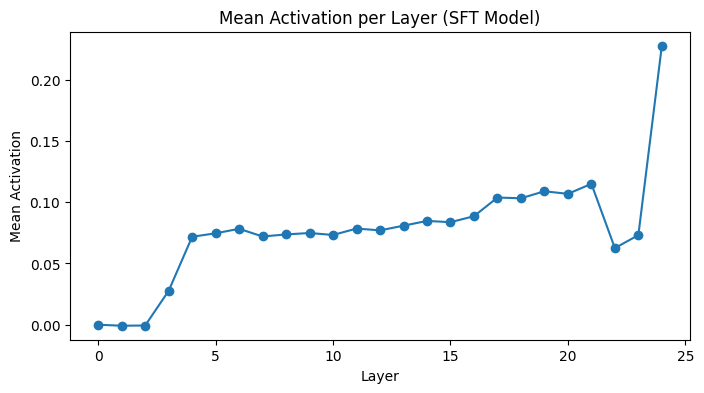

In [29]:
# 7. Activation Statistics
print("\n--- Activation Statistics ---")
inputs = tokenizer(REASONING_QUERY, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = sft_model(**inputs, output_hidden_states=True)
print(f"\nNumber of layers: {len(outputs.hidden_states)}")
print(f"\n{'Layer':<8} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
print("-" * 60)
layer_means = []
for i, h in enumerate(outputs.hidden_states):
    h_np = h.float().cpu().numpy()
    layer_means.append(h_np.mean())
    print(f"{i:<8} {h_np.mean():>12.4f} {h_np.std():>12.4f} {h_np.min():>12.4f} {h_np.max():>12.4f}")
plt.figure(figsize=(8,4))
plt.plot(layer_means, marker='o')
plt.title('Mean Activation per Layer (SFT Model)')
plt.xlabel('Layer')
plt.ylabel('Mean Activation')
plt.show()

In [30]:
# 8. Final Comparison Summary
print("\n" + "="*60)
print("FINAL COMPARISON SUMMARY")
print("="*60)
print("- Token Distribution: SFT model shows entropy {:.4f} for reasoning query.".format(entropy))
print("- Perplexity: Mean perplexity across queries: {:.2f}".format(np.mean(ppls)))
print("- Generation Diversity: Distinct-1 {:.4f}, Distinct-2 {:.4f}, Avg Length {:.1f}".format(d1, d2, avg_len))
print("- Reasoning Patterns: See above for counts in base vs SFT.")
print("- Activation Statistics: See plot and stats above.")
print("- Base Model Output:\n", base_response)
print("- SFT Model Output:\n", sft_response)
print("="*60)
print("ANALYSIS COMPLETE")
print("="*60)


FINAL COMPARISON SUMMARY
- Token Distribution: SFT model shows entropy 1.9408 for reasoning query.
- Perplexity: Mean perplexity across queries: 6.53
- Generation Diversity: Distinct-1 0.2560, Distinct-2 0.4257, Avg Length 41.4
- Reasoning Patterns: See above for counts in base vs SFT.
- Activation Statistics: See plot and stats above.
- Base Model Output:
 To determine how much more money Mia needs to buy the book, we can follow these steps:

1. Identify the cost of the book: $12.
2. Identify the amount of money Mia currently has: $7.
3. Calculate the difference between the cost of the book and the amount of money Mia has:
   \[
   12 - 7 = 5
   \]
4. The result tells us that Mia needs $5 more to buy the book.

Therefore, the amount of additional money Mia needs is \(\boxed{5}\).
- SFT Model Output:
 To determine how much more money Mia needs to buy the book, we can follow these steps:

1. Identify the cost of the book: $12.
2. Identify the amount of money Mia currently has: $7.
3. S